In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import os
% matplotlib inline
plt.ion()

import sys
sys.path.append('../../')
import logomaker

In [2]:
def write_df_and_description(df, description, file_name, index=False, feedback=True):
    """ Write a data frame, with comment, to file"""
    
    # convert description to comment
    comment = '\n'.join(['# %s'%line.strip() for line in description.split('\n')])

    # remove file if it already exists
    if os.path.isfile(file_name):
        os.remove(file_name)        
    
    # open file for appending
    with open(file_name,'a') as f:
        
        # write comment
        f.write(comment+'\n')
        
        # write data frame
        df.to_csv(f, sep='\t', index=index)
    
    # provide feedback if desired
    if feedback:
        # show file name and location
        print('-> saving data to %s:'%file_name)
              
        # preview file
        with open(file_name,'r') as f:
            lines = f.readlines()
            head_length = min(len(lines),15)
            tail_length = min(len(lines),10)
            print(''.join(lines[:head_length]) + '...\n' + ''.join(lines[-tail_length:]))

In [3]:
# Set names of output sequence files
ss_seq_file = '../ss_sequences.txt'
ww_seq_file = '../ww_aligned_sequences.txt'
ars_fgseq_file = '../ars_selected_sequences.txt'
ars_bgseq_file = '../ars_library_sequences.txt'
ars_wtseq_file = '../ars_wt_sequence.txt'
saliency_data_file = '../nn_saliency_values.txt'
crp_sites_file = '../crp_site_sequences.txt'

# Set names of output matrix files
mat_dir = '../../logomaker/examples/matrices/'
ww_mat_file = mat_dir + 'ww_information_matrix.txt'
ss_mat_file = mat_dir + 'ss_probability_matrix.txt'
crp_mat_file = mat_dir + 'crp_energy_matrix.txt'
ars_mat_file = mat_dir + 'ars_enrichment_matrix.txt'
saliency_mat_file = mat_dir + 'nn_saliency_matrix.txt'

In [4]:
### Format saliency data

# write description
description =  """
Saliency values illustrated in Figure 1F.
Data are from Figure 1D of Janganathan et al. (2019), 
and were kindly provided by Kyle Farh and Kishore Jaganathan. 

References:

Jaganathan K et al. Predicting Splicing from Primary Sequence with 
Deep Learning. Cell. 2019 176(3):535–548.e24. 
"""

# load saliency data 
data = np.load('importance_score.npz')
tmp_df = pd.DataFrame(data=data['arr_0'].T, columns=list('ACGT'))

# format saliency data
saliency_data_df = pd.DataFrame()
for i, row in tmp_df.iterrows():
    abs_vals = np.abs(row.values)
    col_num = np.argmax(abs_vals)
    saliency_data_df.loc[i,'character'] = tmp_df.columns[col_num]
    saliency_data_df.loc[i,'value'] = row.iloc[col_num]

# write data and description, then show file
write_df_and_description(df=saliency_data_df, 
                         description=description,
                         file_name=saliency_data_file)

-> saving data to ../nn_saliency_values.txt:
# 
# Saliency values illustrated in Figure 1F.
# Data are from Figure 1D of Janganathan et al. (2019),
# and were kindly provided by Kyle Farh and Kishore Jaganathan.
# 
# References:
# 
# Jaganathan K et al. Predicting Splicing from Primary Sequence with
# Deep Learning. Cell. 2019 176(3):535–548.e24.
# 
character	value
G	-0.0017247200012207031
G	0.03355717658996582
G	0.030026257038116455
G	0.012748241424560547
...
A	-0.004249751567840576
T	0.019003868103027344
A	-0.00032633543014526367
A	-0.010485649108886719
A	0.0017966628074645996
T	0.021005749702453613
T	0.019015133380889893
T	0.010700225830078125
T	0.010440587997436523
C	-0.01064610481262207



In [5]:
logomaker.list_example_datafiles()

['ww_aligned_sequences.txt',
 'ss_sequences.txt',
 'crp_site_sequences.txt',
 'ss_probability_matrix.txt',
 'nn_saliency_values.txt',
 'ww_information_matrix.txt',
 'crp_energy_matrix.txt',
 'nn_saliency_matrix.txt']

In [ ]:
with logomaker.open_example_datafile('nn_saliency_values.txt') as f:
    df = pd.read_csv(f, comment='#', sep='\t')
df.head()

In [ ]:
### Compute saliency matrix

description = """
Saliency matrix illustrated in Figure 1F.
Data are from Figure 1D of Janganathan et al. (2019), 
and were kindly provided by Kyle Farh and Kishore Jaganathan. 

References:

Jaganathan K et al. Predicting Splicing from Primary Sequence with 
Deep Learning. Cell. 2019 176(3):535–548.e24. 
"""

# THIS SHOULD WORK, BUT DOESN'T!
#saliency_mat_df = logomaker.saliency_to_matrix(seq=saliency_data_df['character'], 
#                                               values=saliency_data_df['value'])

# This is more complicated than it needs to be
saliency_mat_df = logomaker.saliency_to_matrix(seq=''.join(saliency_data_df['character']),
                                               values=list(saliency_data_df['value']))

# write data and description, then show file
write_df_and_description(df=saliency_mat_df, 
                         description=description,
                         file_name=saliency_mat_file,
                         index=True)

Description of example matrix "nn_saliency_matrix":
# 
# Saliency matrix illustrated in Figure 1F.
# Data are from Figure 1D of Janganathan et al. (2019),
# and were kindly provided by Kyle Farh and Kishore Jaganathan.
# 
# References:
# 
# Jaganathan K et al. Predicting Splicing from Primary Sequence with
# Deep Learning. Cell. 2019 176(3):535–548.e24.
# 



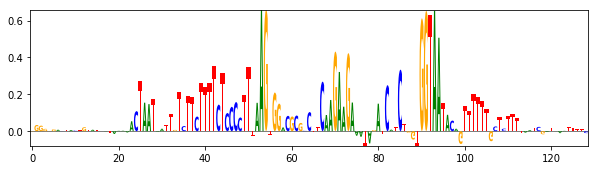

In [6]:
# Check that saliency matrix works with get_example_matrix
df = logomaker.get_example_matrix('nn_saliency_matrix')
logomaker.Logo(df)

In [ ]:
### Format CRP sites data

# load crp sites, taken from RegulonDB
with open('crp_sites.fasta','r') as f:
    lines = f.readlines()
    info = [line.strip() for line in lines if '>' in line]
    seqs = [line.strip() for line in lines if '>' not in line]
    
# clean information
info = ['_'.join(line.split()[1:]) for line in info]
    
# create crp sites dataframe
crp_sites_df = pd.DataFrame()
crp_sites_df['sequence'] = seqs
crp_sites_df['location'] = info

# save list of sites as data frame
crp_sites_df.to_csv(crp_sites_file, sep='\t', index=False)
print('# CRP binding sites saved to %s:'%crp_sites_file)
!head $crp_sites_file

In [ ]:
### Format CRP energy matrix

# load published energy matrix
energy_df = pd.read_csv('crp_tau_final_all.26.txt', delim_whitespace=True, index_col=0)
energy_df.columns = [c[-1] for c in energy_df.columns]
energy_df = logomaker.transform_matrix(energy_df, center_values=True)
energy_df = energy_df/1.62   # convert to kcal/mol

# save energy matrix
energy_df.to_csv(crp_mat_file, sep='\t')
print('# CRP energy matrix saved to %s:'%crp_mat_file)
!head $crp_mat_file

In [ ]:
### Format WW domain sequences

# load alignment of WW domain proteins
in_file = 'Pfam_wwdomain.fa'
with open(in_file, 'r') as f:
    text = f.read()
    lines = text.split('\n')
    seqs = [l.strip().upper() for l in lines if '#' not in l and '>' not in l and len(l.strip())>0]
    
ww_seqs_df = pd.DataFrame()
ww_seqs_df['sequence'] = seqs

ww_seqs_df.to_csv(ww_seq_file, sep='\t', index=False)
print('# WW domain sequences saved to %s:'%ww_seq_file)
!head $ww_seq_file

In [ ]:
### Save WW domain information matrix
    
# create counts matrix
ww_counts_df = logomaker.alignment_to_matrix(ww_seqs_df['sequence'], characters_to_ignore='.-X')

# filter base on counts
num_seqs = ww_counts_df.sum(axis=1)
pos_to_keep = num_seqs > len(seqs)/2
ww_counts_df = ww_counts_df[pos_to_keep]
ww_counts_df.reset_index(drop=True, inplace=True)

# transform to information matrix
ww_info_df = logomaker.transform_matrix(ww_counts_df, from_type='counts', to_type='information')

# save file
ww_info_df.to_csv(ww_mat_file, sep='\t')
print('WW domain matrix computed and saved to %s.'%ww_mat_file)
!head $ww_mat_file

In [ ]:
### Format 5' ss sequences

# load all splice sites
tmp1_df = pd.read_csv('hg38_sss.txt', sep='\t', index_col=0)

# get 5' splice sites
seqs = [s.replace('T','U') for s in tmp1_df['ss5_seq'] if s[3:5] in {'GT','GU'}]
tmp2_df = pd.DataFrame(data=seqs, columns=['sequence'])

# uniquify sequence list
tmp2_df['count'] = 1
ss_seqs_df = tmp2_df.groupby('sequence').sum()
ss_seqs_df.sort_values(by='count', ascending=False, inplace=True)
ss_seqs_df.reset_index(inplace=True)

# save file
ss_seqs_df.to_csv(ss_seq_file, sep='\t', index=False)
print('5\'ss sequences saved to %s.'%ss_seq_file)
!head $ss_seq_file

In [ ]:
### Generate 5'ss motif

# compute probability matrix from sequence alignment
prob_df = logomaker.alignment_to_matrix(ss_seqs_df['sequence'], to_type='probability', pseudocount=0)

# save file
prob_df.to_csv(ss_mat_file, sep='\t')
print('5\'ss probability matrix computed and saved to %s.'%ss_mat_file)
!head $ss_mat_file

In [ ]:
def get_probmat_from_alngz_file(file_name):
    with gzip.open(file_name, 'r') as f:
        txt = [x.decode("utf-8") for x in f]
    
    counts = np.array([int(str(name).strip().split('-')[-1]) for name in txt if '>' in name])
    seqs = [str(s).strip() for s in txt if '>' not in s]
    
    mat = logomaker.alignment_to_matrix(sequences=seqs, 
                                        counts=counts, 
                                        to_type='probability')
    return mat

bg_file = 'data/ARS416_09_B1.qcfilt.aln.full.gz'
fg_file = 'data/ARS416_09_B2.qcfilt.aln.full.gz'

bg_df = get_probmat_from_alngz_file(bg_file)
fg_df = get_probmat_from_alngz_file(fg_file)

enrichment_df = np.log2(fg_df/bg_df)
enrichment_df = logomaker.transform_matrix(enrichment_df, center_values=True)
enrichment_df.loc[:,:] = enrichment_df.values[::-1,::-1]

# show enrichment matrix
logomaker.Logo(enrichment_df)

# save file
enrichment_df.to_csv(ars_mat_file, sep='\t')
print('ARS enrichment matrix computed and saved to %s.'%ars_mat_file)

In [ ]:
def rc(seq):
    """Reverse-complements a DNA sequence"""
    complement = str.maketrans('ATCGN', 'TAGCN')
    return str(seq).upper().translate(complement)[::-1]

# write ars416 seq to file
ars416 = rc(
    'tctaacaaaatagcaaatttcgtcaaaaatgctaagaaataggtt'
    'attactgagtagtatttatttaagtattgtttgtgcacttgcctg'
    'caggccttttgaaaagcaagcataaaagatctaaacataaaatct'
    'gtaaaataacaagat'.upper())
with open('matrices/ars416.txt','w') as f:
    f.write(ars416)